In [2]:
# Poke' Hackathon
# Luca & Francesco, ETH Zurich
# 19 May 20 - 31 May 20

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# import the function for building the matrix with the pokemon features
from function_import import get_matrix_with_features, clamp_prediction
import glob

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.backend as K

import os
print('Current working folder = ' + os.getcwd())

Current working folder = C:\Users\FoS\Dropbox\Data science - ML - AI\McK_Pokemon_Hackathon_05-2020\to_upload_final


# **Load data from pickle files**

In [3]:
# Read data from pickle
f_name = r'./battle_res_aug.pickle'

with open(f_name, 'rb') as fd:
    battle_results = pickle.load(fd)
print('Data read from pickle')

# fill the Nan values present in weak Features with the constant value = 0.6
battle_results = battle_results.fillna(0.6)
print('Nan values filled with the constant value of 0.6!!!')

Data read from pickle
Nan values filled with the constant value of 0.6!!!


In [4]:
# Read labels from pickle
labels_name = r'./battle_res_labels.pickle'

with open(labels_name, 'rb') as fd:
    labels = pickle.load(fd)
print('Data labels from pickle')
print('labels has shape = ' + str(labels.shape))

Data labels from pickle
labels has shape = (2719163,)


# **Preprocessing**

In [5]:
# drop the unused columns
battle_results =battle_results.drop(columns=['Name_1', 'Name_2', 'Type_1_x', 'Type_2_x',
       'Type_1_y', 'Type_2_y'])
print('battle_results has shape = ' + str(battle_results.shape))
display(battle_results.head())

battle_results has shape = (2719163, 26)


Level_1  Price_1  HP_1  Attack_1  Defense_1  Sp_Atk_1  Sp_Def_1  Speed_1  \
0       30      441   150        36        103        47        47       58   
1       36     1227   196       304        237       129       164      197   
2       15      297    92        26         73        33        33       40   
3       40     1401   228       346        270       146       187      224   
4       12      634    91       157        124        70        86      106   

   Legendary_1  pk1_feat_1  ...  Attack_2  Defense_2  Sp_Atk_2  Sp_Def_2  \
0        False         1.0  ...       393        306       164       211   
1        False         1.0  ...       127        365       172       172   
2        False         1.0  ...      1208        947       504       652   
3        False         1.0  ...        47        138        63        63   
4        False         1.0  ...        32         90        41        41   

   Speed_2  Legendary_2  pk2_feat_1  pk2_feat_2  pk2_feat_3  pk2_feat_4  
0      253        False         1.0         0.6         0.6         0.6  
1      200        False         1.0         0.6         0.6         0.6  
2      781        False         1.0         0.6         0.6         0.6  
3       75        False         1.0         0.6         0.6         0.6  
4       51        False         1.0         0.6         0.6         0.6  

[5 rows x 26 columns]

In [5]:
# Optional left out set
battle_results, battle_test, labels, labels_test = train_test_split(battle_results, labels, test_size=0.05, random_state=915)

print('battle_results shape: ', battle_results.shape)
print('battle_test shape:  ', battle_test.shape)
print('labels shape: ', labels.shape)
print('labels_test shape:  ', labels_test.shape)

battle_results shape:  (2583204, 26)
battle_test shape:   (135959, 26)
labels shape:  (2583204,)
labels_test shape:   (135959,)


In [6]:
scaler      = StandardScaler()
scaled_data = scaler.fit_transform(battle_results)

In [7]:
# scale the labels such that they have order 1
max_value = 1000
y_scal = np.array(labels/max_value)

In [8]:
# Optional if left out set 
scaled_data_test = scaler.transform(battle_test)
scaled_data_test = pd.DataFrame(scaled_data_test, columns=battle_test.columns)

y_test_scal = np.array(labels_test/max_value)

# **Model definition - PokeNet**
Create an ensamble of models ensuring diversity training them on different folds and thorugh the stocasticity of the optimization process. Averaging the solution over the ensamble of models increased the model predicitive power, looking at the st dev of their solution we gauge the model uncertainty.

In [8]:
# Define input and output shape for the neural network
input_shape = scaled_data[0].shape
print('Input shape = ' + str(input_shape))
output_shape = y_scal.shape
print('Output shape = ' + str(output_shape))

Input shape = (26,)
Output shape = (2719163,)


In [9]:
# define KFold split
kFold_split = 10
kfold = KFold(n_splits=kFold_split, shuffle=True, random_state=4321)

In [10]:
def create_model():
    # create model
    model = keras.Sequential([
        keras.layers.Dense(units=16, activation='relu', input_shape=input_shape),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.Dense(units=16, activation='relu'),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.Dense(units=8, activation='relu'),
        keras.layers.Dense(units=4, activation='relu'),
        keras.layers.Dense(units=4, activation='relu'),
        keras.layers.Dense(units=4, activation='relu'),
        keras.layers.Dense(units=4, activation='relu'),
        keras.layers.Dense(units=2, activation='relu'),
        keras.layers.Dense(units=2, activation='relu'),
        keras.layers.Dense(units=1, activation='linear')
    ])

    opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
                                epsilon=1e-7, amsgrad=True)
    # compile the model
    model.compile(optimizer=opt, 
                  loss='mean_squared_error',
                  metrics=[])
    
    return model,opt

In [ ]:
cvscores = []
kf_n = 0

for train, test in kfold.split(scaled_data, y_scal):
    
    print('')
    print('==========================================')
    print('kf_n:', kf_n)
    print('==========================================')
    print('')
    
    # define model checkpoint
    model_name = 'Pokemon_model3_LearnRate_e-4_kf_n_' + str(kf_n)
    checkpoint_name = model_name + '_Weights_bestModel.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    # Callback: early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1,
                               mode='auto', baseline=None, restore_best_weights=True)

    callbacks_list = [checkpoint, early_stop]
    
    model,opt = create_model()
    
    # inizialize the weights of the NN
    model.load_weights('init_weights.hdf5')
    
    # fit the model
    model.fit(scaled_data[train], y_scal[train], 
              validation_data = (scaled_data[test], y_scal[test]),
              epochs=1000, 
              batch_size=128, 
              verbose=1,
              callbacks = callbacks_list
             )
    # evaluate the model
    scores = model.evaluate(scaled_data[test], y_scal[test], verbose=0)
    print("mean_squared_error: %.2f%%" % (scores*100))
    cvscores.append(scores)
    
    kf_n += 1
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# **Measure the performance of the PokeNet (ONLY IF THE LEFT OUT SET IS USED)**

In [12]:
# display summury of the model
model, opt = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                432       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2

In [13]:
weights = glob.glob('weights_PokeNet/*.hdf5')

predictions_models = np.zeros((y_test_scal.shape[0], len(weights)))
r2_scores = np.zeros((len(weights)))
split_at = int(battle_test.shape[1]/2)

for count, ele in enumerate(weights):
    print('File', count, 'out of', len(weights)-1)
    model.load_weights(ele)
    
    pred_tmp = model.predict(scaled_data_test)
    predictions_models[:,count] = np.squeeze(pred_tmp)
    print('  --> R2 score 1 vs 2              = ', r2_score(y_test_scal, predictions_models[:,count]))

    inv_potential_battles = np.concatenate((np.array(scaled_data_test)[:,split_at::], np.array(scaled_data_test)[:,0:split_at]), axis=1)
    
    pred_tmp_inv = -1.*model.predict(inv_potential_battles)
    print('  --> R2 score 2 vs 1              = ', r2_score(y_test_scal, np.squeeze(pred_tmp_inv)))
    
    #average the predictions
    predictions_models[:,count] = (predictions_models[:,count] + np.squeeze(pred_tmp_inv))/2
    print('  --> R2 score w/ averaging        = ', r2_score(y_test_scal, predictions_models[:,count]))

    r2_scores[count] = r2_score(y_test_scal, predictions_models[:,count])


File 0 out of 4
  --> R2 score 1 vs 2              =  0.9957098358267285
  --> R2 score 2 vs 1              =  0.995531864715684
  --> R2 score w/ averaging        =  0.9959247637347731
File 1 out of 4
  --> R2 score 1 vs 2              =  0.9956107269393846
  --> R2 score 2 vs 1              =  0.9955038647688788
  --> R2 score w/ averaging        =  0.9958545128612225
File 2 out of 4
  --> R2 score 1 vs 2              =  0.9955614284125843
  --> R2 score 2 vs 1              =  0.9953780248301403
  --> R2 score w/ averaging        =  0.9957867257409547
File 3 out of 4
  --> R2 score 1 vs 2              =  0.9957557530635336
  --> R2 score 2 vs 1              =  0.9956242300103458
  --> R2 score w/ averaging        =  0.9959767767288805
File 4 out of 4
  --> R2 score 1 vs 2              =  0.9956294308190071
  --> R2 score 2 vs 1              =  0.9954614648730543
  --> R2 score w/ averaging        =  0.9958879147433366


In [14]:
# select points with large deviation from the ground truth
idx_e = np.abs(predictions_models[:,0]-y_test_scal) > 2e-9
print('Number of point selected =', np.sum(idx_e))

Number of point selected = 135959


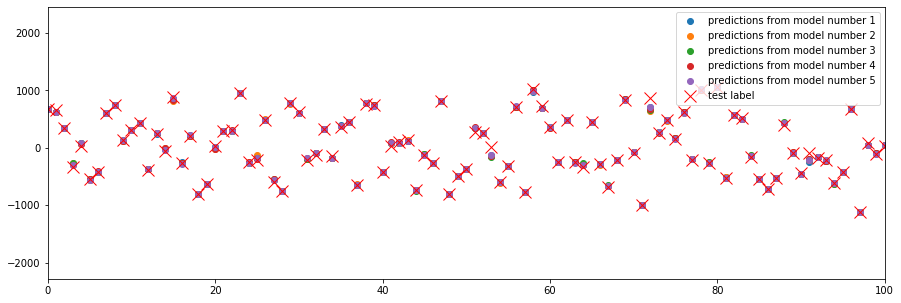

In [15]:
plt.figure(figsize=(15,5))
for i in range(len(weights)):
    plt.plot(predictions_models[idx_e,i]*max_value, '.', markersize=12, label='predictions from model number '+str(i+1))
plt.plot(y_test_scal[idx_e]*max_value, 'rx', markersize=12, label='test label')
plt.xlim((0,100))
plt.legend(loc="best")

In [16]:
avg_prediction = np.mean(predictions_models, axis=1)
avg_prediction = np.squeeze(clamp_prediction(battle_test, avg_prediction.reshape(-1,1)*max_value)/max_value)
print('R2 score = ', r2_score(y_test_scal, avg_prediction))

std_prediction = np.std(predictions_models, axis=1)

R2 score =  0.9960904645222741


/Users/luca/Documents/PokemonDatathlon/PokeFinal/Submission/function_import.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clamp['PredClamped'][X_clamp['test']] = X_clamp['HP_2_inv']


left out =  19545 i.e.  14.375657367294547


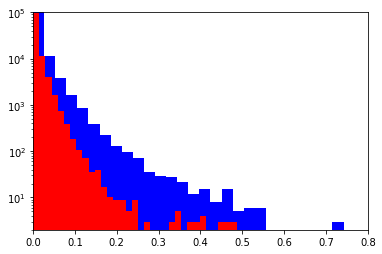

In [17]:
error = np.abs(avg_prediction - y_test_scal)
idxs = std_prediction < 0.0075;

print('left out = ', len(idxs)-sum(idxs), 'i.e. ', 100*(1-sum(idxs)/len(idxs)))

plt.figure()
plt.hist(error, bins = 50, color='b')
plt.hist(error[idxs], bins = 50, color='r')
plt.yscale('log')
plt.xlim((0, 0.8));
plt.ylim((2, 1e5));

# **Select the best team for the PokeLeague**

# Load a table analogous to battle_res as a cross join between av_poke and poke2beat with the possible PokeLeague battle


In [11]:
with open('data.pickle', 'rb') as fd:
    [_,_,_,av_poke,poke2beat] = pickle.load(fd)
print('Data read from pickle')

Data read from pickle


In [12]:
# Read potential battles dataset from pickle
f_name = r'./potential_battles.pickle'

with open(f_name, 'rb') as fd:
    potential_battles, sl_poke_ID = pickle.load(fd)
print('Potential battles loaded from pickle')

# fill the Nan values present in weak Features with the constant value = 0.6
potential_battles = potential_battles.fillna(0.6)
print('Nan values filled with the constant value of 0.6!!!')

Potential battles loaded from pickle
Nan values filled with the constant value of 0.6!!!


In [13]:
potential_battles =potential_battles.drop(columns=['Name_1', 'Name_2', 'Type_1_x', 'Type_2_x',
       'Type_1_y', 'Type_2_y'])
print('potential_battles has shape = ' + str(potential_battles.shape))
potential_battles.head()

potential_battles has shape = (8640, 26)


Level_1  Price_1  HP_1  Attack_1  Defense_1  Sp_Atk_1  Sp_Def_1  Speed_1  \
0        4      346    32        22         17       115        61       99   
1        4      346    32        22         17       115        61       99   
2        4      346    32        22         17       115        61       99   
3        4      346    32        22         17       115        61       99   
4        4      346    32        22         17       115        61       99   

   Legendary_1  pk1_feat_1  ...  Attack_2  Defense_2  Sp_Atk_2  Sp_Def_2  \
0        False         1.0  ...        33         39        22        22   
1        False         1.0  ...       332        362       148       184   
2        False         1.0  ...       405        333        91        91   
3        False         0.6  ...       671        522       935       522   
4        False         1.0  ...       252        150       252       228   

   Speed_2  Legendary_2  pk2_feat_1  pk2_feat_2  pk2_feat_3  pk2_feat_4  
0       50        False         6.0         0.6         0.6         0.6  
1      123        False         1.0         0.6         1.0         0.6  
2      184        False         1.0         0.6         0.6         0.6  
3      768         True         0.6         0.6         0.6         0.6  
4      306        False         1.0         0.6         0.6         0.6  

[5 rows x 26 columns]

In [14]:
potential_battles_scaled = scaler.transform(potential_battles)
split_at = int(potential_battles_scaled.shape[1]/2)
print('potential_battles_scaled has shape = ' + str(potential_battles_scaled.shape))
print('The slip for battle invertion will occur at position = ' + str(split_at))

potential_battles_scaled has shape = (8640, 26)
The slip for battle invertion will occur at position = 13


## Simulate all the possible battles with the PokeNet

In [15]:
model, opt = create_model()
weights = glob.glob('weights_PokeNet/*.hdf5')

predictions_models = np.zeros((potential_battles_scaled.shape[0], len(weights)))
split_at = int(potential_battles_scaled.shape[1]/2)

for count, ele in enumerate(weights):
    print('File', count, 'out of', len(weights)-1)
    model.load_weights(ele)
    
    pred_tmp = model.predict(potential_battles_scaled)
    predictions_models[:,count] = np.squeeze(pred_tmp)

    # invert the battle matrix
    inv_potential_battles = np.concatenate((np.array(potential_battles_scaled)[:,split_at::], np.array(potential_battles_scaled)[:,0:split_at]), axis=1)
    pred_tmp_inv = -1.*model.predict(inv_potential_battles)
    
    #average the predictions
    predictions_models[:,count] = (predictions_models[:,count] + np.squeeze(pred_tmp_inv))/2

avg_prediction = np.mean(predictions_models, axis=1)   
std_prediction = np.std(predictions_models, axis=1)
# Clamp the predictions
predictions_clamped = clamp_prediction(potential_battles, avg_prediction.reshape(-1,1)*max_value)/max_value

print('Done!!!')

W0531 18:39:38.599273 13264 deprecation.py:506] From c:\users\fos\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


File 0 out of 4
File 1 out of 4
File 2 out of 4
File 3 out of 4
File 4 out of 4
Done!!!


C:\Users\FoS\Dropbox\Data science - ML - AI\McK_Pokemon_Hackathon_05-2020\to_upload_final\function_import.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clamp['PredClamped'][X_clamp['test']] = X_clamp['HP_2_inv']


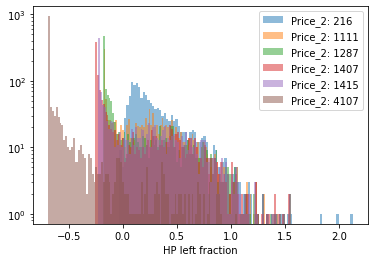

In [16]:
for i in np.sort(potential_battles.Price_2.unique()):
    plt.hist(predictions_clamped[potential_battles.Price_2==i], bins=100, alpha=0.5, label='Price_2: '+str(i));    
plt.yscale('log');
plt.xlabel('HP left fraction');
plt.legend();

## Create a table with the predicted outcome of each bottle

In [17]:
battles_outcome = pd.DataFrame(sl_poke_ID).copy()
battles_outcome = battles_outcome.merge(potential_battles[['Price_1', 'HP_1', 'Price_2', 'HP_2']], left_index=True, right_index=True)
# add the column with the prediction rescaled
battles_outcome = battles_outcome.merge(pd.DataFrame( predictions_clamped * max_value , columns=['BattleResult'] ),
                                        left_index=True, right_index=True)
battles_outcome = battles_outcome.merge(pd.DataFrame( std_prediction * max_value , columns=['StdResult'] ),
                                        left_index=True, right_index=True)
battles_outcome.head(7)

SelectedPokemonID  Price_1  HP_1  Price_2  HP_2  BattleResult  StdResult
0                  1      346    32      216    50    -27.016580   2.864792
1                  1      346    32     1407   258   -256.821227   1.000833
2                  1      346    32     1287   183   -181.914747   1.936090
3                  1      346    32     4107   689   -689.000000   1.557812
4                  1      346    32     1415   227   -225.471449   0.468382
5                  1      346    32     1111   177   -177.000000   2.158632
6                  2      614    80      216    50     66.284919   8.292182

In [18]:
# Calculate the residual HP in % after the battle
battles_outcome['HP_left_f'] = battles_outcome['BattleResult'] / battles_outcome['HP_1']

# Set to 0 the rows where it's <0 (i.e., we lost)
battles_outcome['HP_left_f'][ battles_outcome['HP_left_f']<0. ] = np.nan

c:\users\fos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
# Clean up selections which are sub-optimal

# max price I want to spend for a pokemon
max_price = 3500.
# Delete the pokemons which are too expensive
too_expensive = battles_outcome[battles_outcome.Price_1>max_price].index
bt_cl = battles_outcome.drop( too_expensive , axis=0)
print('Poke cleared because too expensive:', len(too_expensive))

# Delete all the selections where we lose (there it's best to just put a cheap pokemon)
lost_btl = bt_cl[ bt_cl.BattleResult<0. ].index
bt_cl.drop(lost_btl, axis=0, inplace=True)
print('Poke deleted because they lost the battle:', len(lost_btl))

Poke cleared because too expensive: 1116
Poke deleted because they lost the battle: 4210


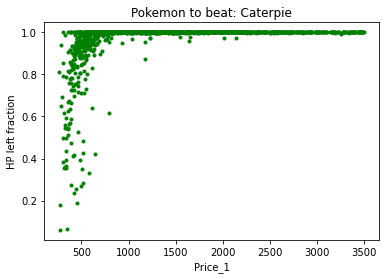

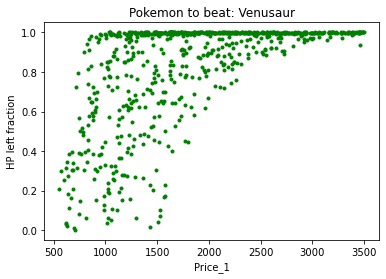

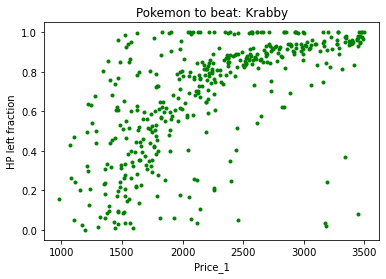

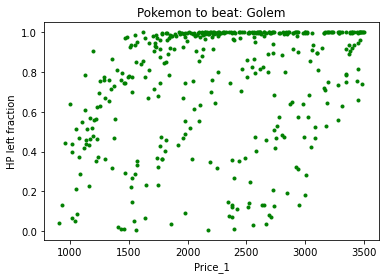

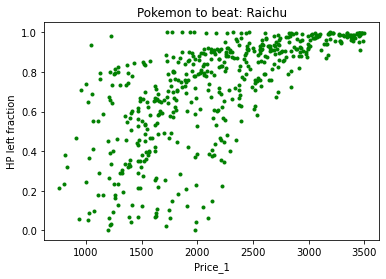

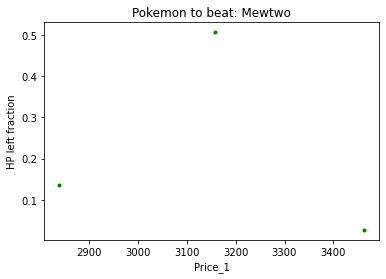

In [20]:
price_2_unique = battles_outcome.Price_2.unique()
std_thr = 800

price_2_unique.sort()
for prc in price_2_unique :
    temp = bt_cl[bt_cl.Price_2 == prc]
    idxs_m = temp.StdResult < std_thr
    idxs_p = temp.StdResult > std_thr
    plt.figure()
    plt.title('Pokemon to beat: ' + str(poke2beat[poke2beat['Price_2']==prc]['Name_2'].values[0]))
    plt.plot(temp[idxs_m].Price_1, temp[idxs_m].HP_left_f, 'g.')
    plt.plot(temp[idxs_p].Price_1, temp[idxs_p].HP_left_f, 'r.')
    plt.xlabel('Price_1')
    plt.ylabel('HP left fraction')
    

In [21]:
# For price_2 = 4107 it doesn't make sense to fight, we'll just put the cheapest poke' there
print('Total possible battles at this point = ', bt_cl.shape[0])
forfait_price = 1410.

lost_btl = bt_cl[ bt_cl.Price_2>forfait_price ].index
bt_cl.drop(lost_btl, axis=0, inplace=True)
print('Battles we forfait:', len(lost_btl))

std_btl = bt_cl[ bt_cl.StdResult>std_thr ].index
bt_cl.drop(std_btl, axis=0, inplace=True)
print('Battles we are not sure:', len(std_btl))

# Remove that pokemon from the price_list of the opponents
price_2_unique = price_2_unique[price_2_unique < forfait_price]
print('Unique price_2:', price_2_unique)

Total possible battles at this point =  3314
Battles we forfait: 516
Battles we are not sure: 0
Unique price_2: [ 216 1111 1287 1407]


## Define an efficient frontier
We don't want to pay more to get less so we define the efficient frontier of poke' optimization
In practice it bins the outcomes of each battle and select only the best *k* options

In [22]:
shortlist = bt_cl.copy()
# parameter to select pokemon close to the frontier
delta = 0.00003

for prc in price_2_unique:
    print('Working on price_2:', prc)
    idxs_del=[0] # Just to have len>0 at the first iteration
    
    while (len(idxs_del)>0) :
        # Select poke fighting against a specific opponent
        idxs = shortlist[ shortlist.Price_2 == prc ].index

        tmp_battle = shortlist.loc[idxs].sort_values(by=['Price_1'])

        # For those pokemon we pay more to get less, we don't want them
        if prc == price_2_unique[0]:
            idxs_del = tmp_battle[tmp_battle.diff().HP_left_f < 0.0001].index
        else:
            idxs_del = tmp_battle[tmp_battle.diff().HP_left_f + delta < 0.0001].index
            
        shortlist.drop(idxs_del, axis=0, inplace=True)
        print('  --> Dropped poke:', len(idxs_del), 'out of', len(idxs))

display(shortlist.sort_values(by='Price_2'))

Working on price_2: 216
  --> Dropped poke: 925 out of 1243
  --> Dropped poke: 226 out of 318
  --> Dropped poke: 56 out of 92
  --> Dropped poke: 19 out of 36
  --> Dropped poke: 10 out of 17
  --> Dropped poke: 3 out of 7
  --> Dropped poke: 1 out of 4
  --> Dropped poke: 0 out of 3
Working on price_2: 1111
  --> Dropped poke: 385 out of 725
  --> Dropped poke: 168 out of 340
  --> Dropped poke: 78 out of 172
  --> Dropped poke: 47 out of 94
  --> Dropped poke: 17 out of 47
  --> Dropped poke: 11 out of 30
  --> Dropped poke: 3 out of 19
  --> Dropped poke: 1 out of 16
  --> Dropped poke: 0 out of 15
Working on price_2: 1287
  --> Dropped poke: 213 out of 434
  --> Dropped poke: 100 out of 221
  --> Dropped poke: 52 out of 121
  --> Dropped poke: 29 out of 69
  --> Dropped poke: 14 out of 40
  --> Dropped poke: 8 out of 26
  --> Dropped poke: 5 out of 18
  --> Dropped poke: 1 out of 13
  --> Dropped poke: 0 out of 12
Working on price_2: 1407
  --> Dropped poke: 196 out of 396
  --> 

SelectedPokemonID  Price_1  HP_1  Price_2  HP_2  BattleResult  \
8280               1381      267    68      216    50     55.199468   
5820                971      288    51      216    50     47.857440   
8580               1431      300    53      216    50     53.000000   
5063                844      993   195     1111   177    193.222916   
8315               1386      845   239     1111   177    231.313181   
8309               1385      719   197     1111   177    143.049121   
8303               1384      631   171     1111   177     59.191668   
7343               1224      793   162     1111   177    145.895851   
7337               1223      738   151     1111   177    120.062041   
6431               1072      946   167     1111   177    165.176642   
5057                843      614   162     1111   177     51.293850   
3689                615      647   182     1111   177     69.793761   
8609               1435      824   176     1111   177    165.763593   
2783                464      572   159     1111   177     47.757959   
791                 132      673   115     1111   177     45.549476   
1403                234      858   121     1111   177    118.839908   
2777                463      555   155     1111   177     32.070041   
1409                235     1036   146     1111   177    146.000000   
458                  77     1827   405     1287   183    405.000000   
2498                417     1209   260     1287   183    128.501868   
5552                926     1070   221     1287   183     95.262253   
452                  76     1623   360     1287   183    359.099889   
5564                928     1274   265     1287   183    180.029690   
2000                334     1107   271     1287   183    127.427626   
1994                333      984   240     1287   183     37.342441   
8372               1396     1529   291     1287   183    286.847830   
3284                548     1387   269     1287   183    229.566598   
7586               1265     1347   231     1287   183    185.298371   
584                  98     1468   307     1287   183    294.341934   
5558                927     1217   253     1287   183    160.758138   
6757               1127      998   195     1407   258    124.909627   
6799               1134      912   166     1407   258      6.815636   
6763               1128     1129   221     1407   258    173.543179   
6751               1126      956   187     1407   258     82.894135   
4489                749     1487   255     1407   258    249.461603   
4483                748     1465   251     1407   258    243.887031   
4177                697     1196   324     1407   258    293.038845   
4111                686     1551   378     1407   258    373.169136   
7213               1203      935   280     1407   258     36.782289   
451                  76     1623   360     1407   258    360.000000   

      StdResult  HP_left_f  
8280   4.639103   0.811757  
5820   2.795267   0.938381  
8580   1.024751   1.000000  
5063   1.560414   0.990887  
8315   1.128749   0.967838  
8309   8.781690   0.726138  
8303   8.849504   0.346150  
7343   3.305203   0.900592  
7337   3.572504   0.795113  
6431   2.636218   0.989082  
5057   3.121562   0.316629  
3689   7.164533   0.383482  
8609   2.707343   0.941839  
2783   8.628407   0.300365  
791   15.679238   0.396082  
1403   3.221655   0.982148  
2777   9.201030   0.206903  
1409   1.168007   1.000000  
458    0.438897   1.000000  
2498   6.212052   0.494238  
5552   8.666547   0.431051  
452    1.857232   0.997500  
5564   4.703394   0.679357  
2000   4.248482   0.470213  
1994   3.005167   0.155594  
8372   2.418926   0.985731  
3284   4.663138   0.853407  
7586   7.059838   0.802157  
584    5.241033   0.958769  
5558   6.295586   0.635408  
6757   4.481249   0.640562  
6799  10.756210   0.041058  
6763   1.323174   0.785263  
6751   9.382545   0.443284  
4489   3.120699   0.978281  
4483   3.829823   0.971661  
4177   8.656576   0.9

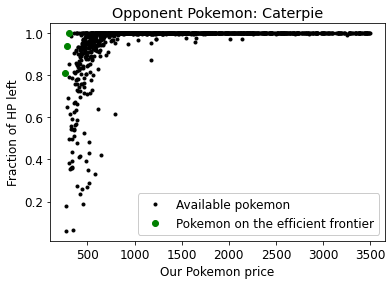

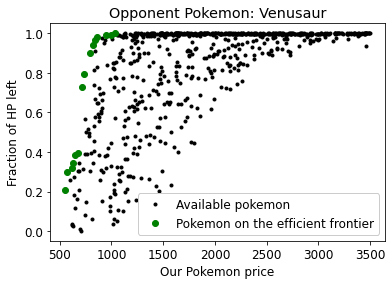

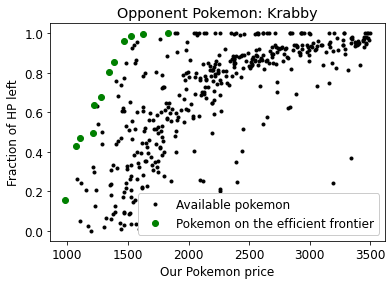

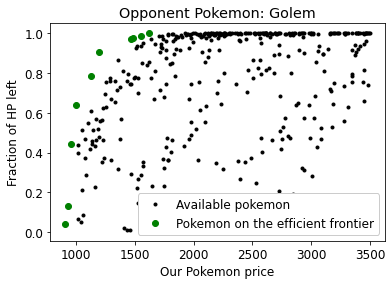

In [49]:
plt.rcParams.update({'font.size': 12})
for prc in price_2_unique :
    plt.figure()
    bt_cl[bt_cl.Price_2 == prc].plot(x='Price_1', y='HP_left_f', style='k.', ax=plt.gca());
    shortlist[shortlist.Price_2 == prc].plot(x='Price_1', y='HP_left_f', style='go', ax=plt.gca());
    ax = plt.gca()
    ax.set_xlabel("Our Pokemon price")
    ax.set_ylabel("Fraction of HP left")
    plt.title('Opponent Pokemon: ' + str(poke2beat[poke2beat['Price_2']==prc]['Name_2'].values[0]))
    leg = ax.legend(["Available pokemon", "Pokemon on the efficient frontier"], loc='lower right');
    leg.get_frame().set_alpha(1)
    plt.savefig(str(str(poke2beat[poke2beat['Price_2']==prc]['Name_2'].values[0])) + '.png', dpi=450)
    plt.show()

### Look exhaustivelt at all the combinations of remaining pokemons
Now we only have few pokes and we can just try exhaustively the different combinations

In [24]:
poke_list=[]
for prc in price_2_unique :
    poke_list.append(shortlist[shortlist.Price_2 == prc].index.values)

In [25]:
poke_comb = np.array(np.meshgrid(*poke_list)).T.reshape(-1,price_2_unique.shape[0])
print('Total possible comb:', poke_comb.shape)

Total possible comb: (5400, 4)


In [26]:
res = np.zeros([poke_comb.shape[0], 6])

print("Calculating price and score for each possible combination ...")
for i, comb in enumerate(poke_comb):
    res[i,0] = shortlist.loc[comb]['Price_1'].sum()
    res[i,1] = shortlist.loc[comb]['HP_left_f'].sum()/6
    res[i,2] = shortlist.loc[comb]['StdResult'].mean()
    res[i,3] = shortlist.loc[comb]['StdResult'].min()
    res[i,4] = shortlist.loc[comb]['StdResult'].max()
    res[i,5] = res[i,1]/res[i,4]
    

print('Done!!')

Calculating price and score for each possible combination ...
Done!!


The price we have to pay to put a Pokemon in the battles we forfait is = 470



Price_tot  HP_left_f  StdResult_mean  StdResult_min  StdResult_max  \
3414     3020.0   0.431878        3.020918       1.024751       4.481249   
3384     3008.0   0.421608        3.463547       2.795267       4.481249   
3417     3001.0   0.420382        4.323214       1.024751       8.781690   
3387     2989.0   0.410112        4.765843       2.795267       8.781690   
3590     3015.0   0.409183        5.334270       1.024751       8.666547   
...         ...        ...             ...            ...            ...   
3591     2982.0   0.398040        4.323527       1.024751       8.666547   
3589     2940.0   0.395330        5.700238       1.024751       8.666547   
3426     3007.0   0.394297        3.661640       2.795267       4.481249   
3566     2987.0   0.392691        6.198142       2.795267       8.849504   
3424     2965.0   0.391587        5.038351       2.795267       8.628407   

      SharpeValue  
3414     0.096374  
3384     0.094083  
3417     0.047870  
3387     0.046701  
3590     0.047214  
...           ...  
3591     0.045928  
3589     0.045616  
3426     0.087988  
3566     0.044374  
3424     0.045383  

[20 rows x 6 columns]

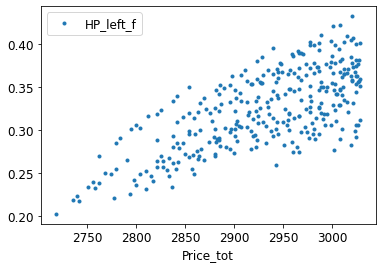

In [31]:
cheap_poke = (av_poke.Price_1.values).copy()
cheap_poke.sort()

base_price = np.sum(cheap_poke[0:6-len(price_2_unique)])
print('The price we have to pay to put a Pokemon in the battles we forfait is =', base_price)
print('')

df_res = pd.DataFrame(res, columns=['Price_tot', 'HP_left_f', 'StdResult_mean', 'StdResult_min', 'StdResult_max', 'SharpeValue'])
df_res.join(pd.DataFrame(poke_comb), how='left')
df_res.sort_values(by='HP_left_f', inplace=True, ascending=False)

idxs_drop = df_res[df_res['Price_tot'] > 3500.-base_price].index
df_res.drop(idxs_drop, axis=0, inplace = True)

display(df_res.head(20))

if len(df_res):
    df_res.plot(x='Price_tot', y='HP_left_f', style='.')
else:
    print('No dream team possible to buy!!!')

In [32]:
print('The team with the highest SharpeValue is:')
df_res[df_res.SharpeValue.values == np.max(df_res.SharpeValue.values)]

The team with the highest SharpeValue is:


Price_tot  HP_left_f  StdResult_mean  StdResult_min  StdResult_max  \
3951     3027.0   0.376248        2.118663       1.024751       3.121562   

      SharpeValue  
3951     0.120532

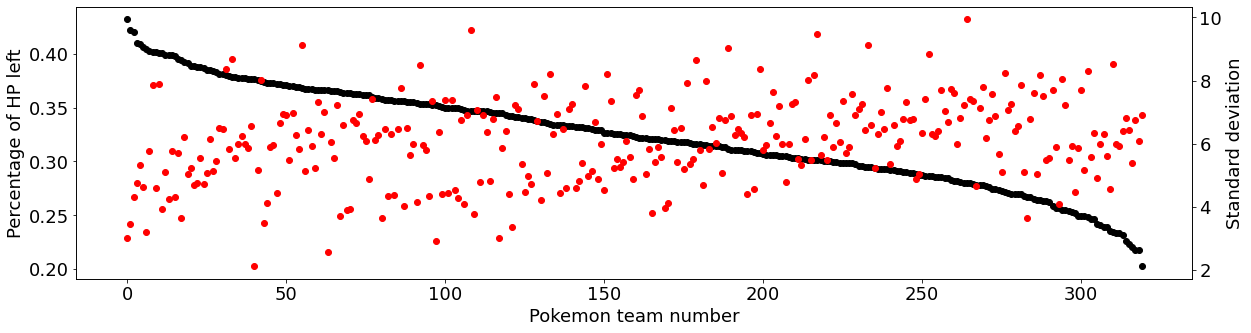

In [34]:
plt.rcParams.update({'font.size': 18});
plt.figure(figsize=(20,5));
plt.plot(df_res.HP_left_f.values, 'ko');
ax = plt.gca();
ax.set_ylabel("Percentage of HP left");
ax.set_xlabel("Pokemon team number");
ax2 = plt.gca().twinx();
plt.plot(df_res.StdResult_mean.values, 'ro');
ax2.set_ylabel("Standard deviation");
#plt.plot(df_res.StdResult_max.values, 'bo')
#plt.xlim((0,100))

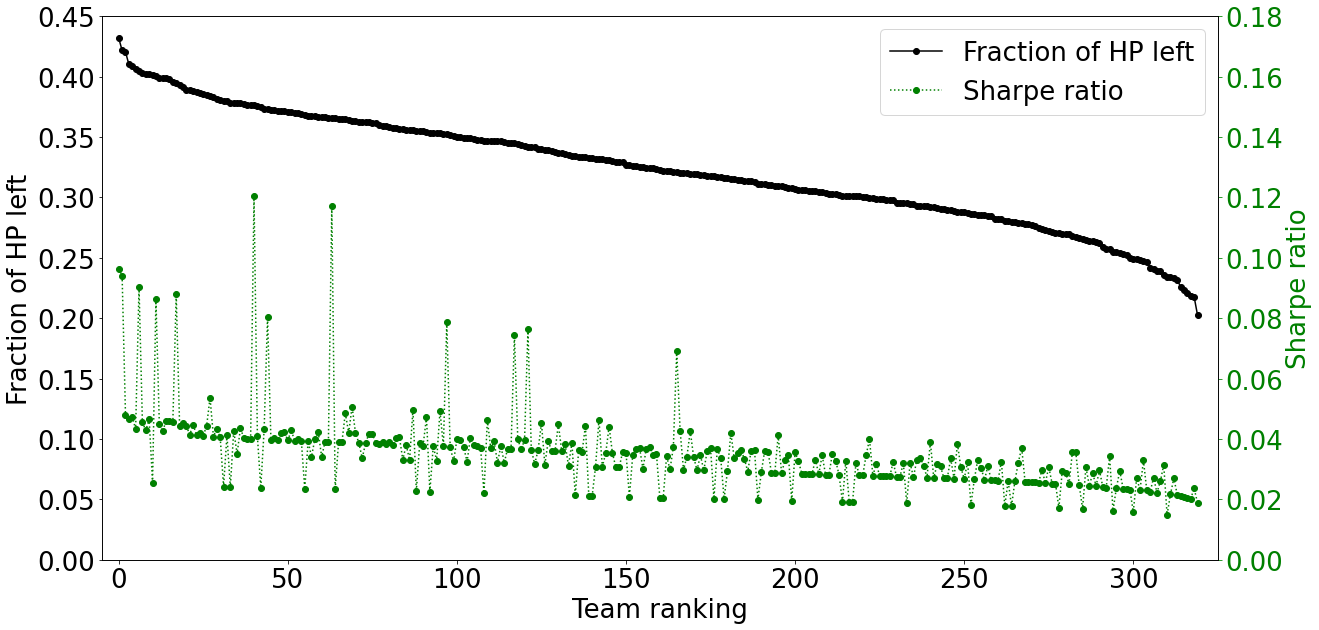

In [48]:
sharpe_value = df_res.HP_left_f/df_res.StdResult_max
plt.rcParams.update({'font.size': 26})

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#ax.yaxis.label.set_color('0.5')
ax.tick_params(axis='y', colors='k')
lns1 = ax.plot(df_res.HP_left_f.values, color='k',linestyle = '-', marker = 'o', label = 'Fraction of HP left')
plt.gca().set_ylim([0,0.45])
ax.set_ylabel("Fraction of HP left")
ax.set_xlabel("Team ranking")
leg = ax.legend(["Fraction of HP left"], loc='upper right');
ax2 = ax.twinx()
lns2 = ax2.plot(sharpe_value.values, 'o', color='g', linestyle = ':', label = 'Sharpe ratio')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax2.set_ylabel("Sharpe ratio")
ax2.yaxis.label.set_color('g')
ax2.tick_params(axis='y', colors='g')
plt.gca().set_ylim([0,0.18])
plt.gca().set_xlim([-5,325])
leg.get_frame().set_alpha(1)
plt.savefig('SharpeRatio.png', dpi=450)
#plt.xlim((0,100))

In [36]:
pokemon_team_arr = [3414, 3951]
for pokemon_team in pokemon_team_arr :
    print('')
    print('===============================')
    print('====== Config: ', pokemon_team, '==========')
    print('===============================')
    display(df_res.loc[pokemon_team])
    display(shortlist.loc[poke_comb[pokemon_team]])
    display(av_poke.loc[shortlist.loc[poke_comb[pokemon_team]].SelectedPokemonID-1])


====== Config:  3414 ==========


Price_tot         3020.000000
HP_left_f            0.431878
StdResult_mean       3.020918
StdResult_min        1.024751
StdResult_max        4.481249
SharpeValue          0.096374
Name: 3414, dtype: float64

SelectedPokemonID  Price_1  HP_1  Price_2  HP_2  BattleResult  \
8580               1431      300    53      216    50     53.000000   
7337               1223      738   151     1111   177    120.062041   
1994                333      984   240     1287   183     37.342441   
6757               1127      998   195     1407   258    124.909627   

      StdResult  HP_left_f  
8580   1.024751   1.000000  
7337   3.572504   0.795113  
1994   3.005167   0.155594  
6757   4.481249   0.640562

Name_1  Level_1  Price_1  HP_1  Attack_1  Defense_1  Sp_Atk_1  \
1430      Zubat        9      300    53        53         43        36   
1222    Spearow       39      738   151       157         80        81   
332   Exeggcute       42      984   240       113        226       167   
1126  Sandshrew       47      998   195       240        278        63   

      Sp_Def_1  Speed_1  Legendary_1  SelectedPokemonID  
1430        48       67        False               1431  
1222        81      188        False               1223  
332        125      113        False                333  
1126        94      128        False               1127


====== Config:  3951 ==========


Price_tot         3027.000000
HP_left_f            0.376248
StdResult_mean       2.118663
StdResult_min        1.024751
StdResult_max        3.121562
SharpeValue          0.120532
Name: 3951, dtype: float64

SelectedPokemonID  Price_1  HP_1  Price_2  HP_2  BattleResult  \
8580               1431      300    53      216    50     53.000000   
5057                843      614   162     1111   177     51.293850   
1994                333      984   240     1287   183     37.342441   
6763               1128     1129   221     1407   258    173.543179   

      StdResult  HP_left_f  
8580   1.024751   1.000000  
5057   3.121562   0.316629  
1994   3.005167   0.155594  
6763   1.323174   0.785263

Name_1  Level_1  Price_1  HP_1  Attack_1  Defense_1  Sp_Atk_1  \
1430      Zubat        9      300    53        53         43        36   
842    Nidorana       33      614   162        94        107        83   
332   Exeggcute       42      984   240       113        226       167   
1127  Sandshrew       51     1129   221       271        314        71   

      Sp_Def_1  Speed_1  Legendary_1  SelectedPokemonID  
1430        48       67        False               1431  
842         83       85        False                843  
332        125      113        False                333  
1127       107      145        False               1128

In [37]:
team_submission = poke2beat.drop(columns=['SelectedPokemonID'])
team_submission = team_submission.merge(shortlist.loc[poke_comb[3414]][['SelectedPokemonID', 'Price_2']], how="left", left_on='Price_2', right_on='Price_2').fillna(0)
team_submission

Name_2  Level_2 WeatherAndTime  Price_2  HP_2  Attack_2  Defense_2  \
0  Caterpie        5           Rain      216    50        33         39   
1     Golem       42          Windy     1407   258       332        362   
2    Krabby       50           Rain     1287   183       405        333   
3    Mewtwo       73        Unknown     4107   689       671        522   
4    Raichu       41          Night     1415   227       252        150   
5  Venusaur       30          Night     1111   177       173        174   

   Sp_Atk_2  Sp_Def_2  Speed_2  Legendary_2  SelectedPokemonID  
0        22        22       50        False             1431.0  
1       148       184      123        False             1127.0  
2        91        91      184        False              333.0  
3       935       522      768         True                0.0  
4       252       228      306        False                0.0  
5       208       208      171        False             1223.0

In [38]:
print('From this list we take the cheapest pokemon based on how many battle we forfait')
av_poke.sort_values(by=['Price_1'])

From this list we take the cheapest pokemon based on how many battle we forfait


Name_1  Level_1  Price_1  HP_1  Attack_1  Defense_1  Sp_Atk_1  \
610     Kakuna        1      205    45        25         50        25   
200    Diglett        1      265    10        55         25        35   
1380    Weedle       13      267    68        45         38        26   
1090   Rattata        4      274    37        59         37        27   
700   Magikarp       13      277    53        10         69        17   
...        ...      ...      ...   ...       ...        ...       ...   
48    Arcanine       95     6737  1163      1303        982      1176   
179   Cloyster       99     6945   764      1252       2336      1095   
678    Machamp       97     6951  1330      1764       1087       877   
679    Machamp       99     7350  1406      1865       1149       928   
49    Arcanine       98     7526  1299      1456       1097      1313   

      Sp_Def_1  Speed_1  Legendary_1  SelectedPokemonID  
610         25       35        False                611  
200         45       95        False                201  
1380        26       64        False               1381  
1090        37       77        False               1091  
700         26      102        False                701  
...        ...      ...          ...                ...  
48         982     1131        False                 49  
179        586      912        False                180  
678       1144      749        False                679  
679       1210      792        False                680  
49        1097     1264        False                 50  

[1440 rows x 11 columns]